# TextRank 
명사, 동사, 형용사와 같은 단어만을 이용하여 단어 그래프를 만드는데 이용.
a와 the같은 단어들이 압도적으로 높은 co-ocurrence를 지니기 때문임

1.  키워드 추출 기능
2.  핵심 문장 추출 기능 

#### Keyword Extraction

In [25]:
from collections import Counter

#sents : 문장들 
#tokenize : 문장을 단어열로 나눔
#min_count : 최소 빈도수 지정

def scan_vocabulary(sents, tokenize, min_count=2):
    counter = Counter(w for sent in sents for w in tokenize(sent))
    counter = {w:c for w,c in counter.items() if c >= min_count}
    idx_to_vocab = [w for w, _ in sorted(counter.items(), key=lambda x:-x[1])]
    vocab_to_idx = {vocab:idx for idx, vocab in enumerate(idx_to_vocab)}
    return idx_to_vocab, vocab_to_idx

In [26]:
from collections import defaultdict

#단어 간의 유사도를 정의하기 위해서 두 단어의 co-occurrence를 계산해야함

#co-occurrence는 문장 내에서 두 단어의 간격이 window인 횟수이다.
#window 값은 논문 요약에서는 2~8, 문장 내에 함꼐 등장한 모든 경우를 찾고 싶다면 -1
#그래프가 dense해지는 것을 방지하고 싶다면 min_coocurrence를 이용하여 sparse하게 만듬

def cooccurrence(tokens, vocab_to_idx, window=2, min_cooccurrence=2):
    counter = defaultdict(int)
    for s, tokens_i in enumerate(tokens):
        vocabs = [vocab_to_idx[w] for w in tokens_i if w in vocab_to_idx]
        n = len(vocabs)
        for i, v in enumerate(vocabs):
            if window <= 0:
                b, e = 0, n
            else:
                b = max(0, i - window)
                e = min(i + window, n)
            for j in range(b, e):
                if i == j:
                    continue
                counter[(v, vocabs[j])] += 1
                counter[(vocabs[j], v)] += 1
    counter = {k:v for k,v in counter.items() if v >= min_cooccurrence}
    n_vocabs = len(vocab_to_idx)
    return dict_to_mat(counter, n_vocabs, n_vocabs)

In [27]:
from scipy.sparse import csr_matrix

#dict of dict형식의 그래프를 scipy의 sparse matrix로 변환하는 함수
def dict_to_mat(d, n_rows, n_cols):
    rows, cols, data = [], [], []
    for (i, j), v in d.items():
        rows.append(i)
        cols.append(j)
        data.append(v)
    return csr_matrix((data, (rows, cols)), shape=(n_rows, n_cols))

In [28]:
#명사, 동사, 형용사와 같은 유의미한 단어만 추출함
#불필요한 단어를 걸러내고 필요한 단어 혹은 품사만 return 하는 함수여야함

def word_graph(sents, tokenize=None, min_count=2, window=2, min_cooccurrence=2):
    idx_to_vocab, vocab_to_idx = scan_vocabulary(sents, tokenize, min_count)
    tokens = [tokenize(sent) for sent in sents]
    g = cooccurrence(tokens, vocab_to_idx, window, min_cooccurrence, verbose)
    return g, idx_to_vocab

In [29]:
# 만들어진 그래프에 PageRank를 학습하는 함수 생성
#x 는 co-occurrence 그래프일 수 있으니 column sum이 1이 되되록 L1정규화 진행
# 이렇게 만들어진 것을 A라 함

def textrank_keyword(sents, tokenize, min_count, window, min_cooccurrence, df=0.85, max_iter=30, topk=30):
    g, idx_to_vocab = word_graph(sents, tokenize, min_count, window, min_cooccurrence)
    R = pagerank(g, df, max_iter).reshape(-1)
    idxs = R.argsort()[-topk:]
    keywords = [(idx_to_vocab[idx], R[idx]) for idx in reversed(idxs)]
    return keywords

#### Key-sentence Extraction



In [30]:
def textrank_keysentence(sents, tokenize, min_count, similarity, df=0.85, max_iter=30, topk=5):
    g = sent_graph(sents, tokenize, min_count, min_sim, similarity)
    R = pagerank(g, df, max_iter).reshape(-1)
    idxs = R.argsort()[-topk:]
    keysents = [(idx, R[idx], sents[idx]) for idx in reversed(idxs)]
    return keysents

#### Experiments

In [31]:
from konlpy.tag import Komoran

komoran = Komoran()
def komoran_tokenize(sent):
    words = komoran.pos(sent, join=True)
    words = [w for w in words if ('/NN' in w or '/XR' in w or '/VA' in w or '/VV' in w)]
    return words

In [34]:
#!pip install pytextrank
from pytextrank import KeywordSummarizer

keyword_extractor = KeywordSummarizer(
    tokenize = komoran_tokenize,
    window = -1,
    verbose = False
)

keywords = keyword_extractor.summarize(sents, topk=30)

ImportError: ignored

# Tokenize Korean
- morphs : 형태소 추출
- pos : 품사 태깅
- nouns : 명사 추출

In [43]:
from konlpy.tag import Okt
okt = Okt()
print (okt.morphs("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

print(okt.pos("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

print(okt.nouns("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

['윤영주', '는', '프렌', '차', '이즈', '커피집', '에', '와서', '모카', '할라', '치노', '를', '마신다']
[('윤영주', 'Noun'), ('는', 'Josa'), ('프렌', 'Noun'), ('차', 'Noun'), ('이즈', 'Noun'), ('커피집', 'Noun'), ('에', 'Josa'), ('와서', 'Verb'), ('모카', 'Noun'), ('할라', 'Verb'), ('치노', 'Noun'), ('를', 'Josa'), ('마신다', 'Verb')]
['윤영주', '프렌', '차', '이즈', '커피집', '모카', '치노']


In [44]:
from konlpy.tag import Kkma
kkma= Kkma()
print(kkma.morphs("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

print(kkma.pos("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

print(kkma.nouns("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

['윤', '영주', '는', '프렌', '차', '이즈', '커피', '집', '에', '오', '아서', '모', '카', '하', 'ㄹ라', '하', '지', '노', '를', '마시', 'ㄴ다']
[('윤', 'NNG'), ('영주', 'NNG'), ('는', 'JX'), ('프렌', 'UN'), ('차', 'NNG'), ('이즈', 'NNG'), ('커피', 'NNG'), ('집', 'NNG'), ('에', 'JKM'), ('오', 'VV'), ('아서', 'ECD'), ('모', 'NNG'), ('카', 'NNG'), ('하', 'VV'), ('ㄹ라', 'ECD'), ('하', 'VX'), ('지', 'ECS'), ('노', 'NNG'), ('를', 'JKO'), ('마시', 'VV'), ('ㄴ다', 'EFN')]
['윤', '윤영주', '영주', '프렌', '프렌차이즈', '차', '이즈', '커피', '커피집', '집', '모', '모카', '카', '노']


In [46]:
from konlpy.tag import Hannanum 
hannanum = Hannanum()

print(hannanum.morphs("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

print(hannanum.pos("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

print(hannanum.nouns("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

['윤영주', '는', '프렌차이즈', '커피집', '에', '오', '아', '모카', '할라치노', '를', '마', '이', '시ㄴ다']
[('윤영주', 'N'), ('는', 'J'), ('프렌차이즈', 'N'), ('커피집', 'N'), ('에', 'J'), ('오', 'P'), ('아', 'E'), ('모카', 'N'), ('할라치노', 'N'), ('를', 'J'), ('마', 'N'), ('이', 'J'), ('시ㄴ다', 'E')]
['윤영주', '프렌차이즈', '커피집', '모카', '할라치노', '마']


In [47]:
from konlpy.tag import Komoran
komoran = Komoran()

print(komoran.morphs("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

print(komoran.pos("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

print(komoran.nouns("윤영주는 프렌차이즈 커피집에 와서 모카 할라치노를 마신다"))

['윤', '영주', '는', '프렌', '차', '이즈', '커피집', '에', '오', '아서', '모카', '할라', '치노', '를', '마시', 'ㄴ다']
[('윤', 'NNP'), ('영주', 'NNP'), ('는', 'JX'), ('프렌', 'NNP'), ('차', 'NNB'), ('이즈', 'NNP'), ('커피집', 'NNP'), ('에', 'JKB'), ('오', 'VV'), ('아서', 'EC'), ('모카', 'NNP'), ('할라', 'NNP'), ('치노', 'NNP'), ('를', 'JKO'), ('마시', 'VV'), ('ㄴ다', 'EC')]
['윤', '영주', '프렌', '차', '이즈', '커피집', '모카', '할라', '치노']


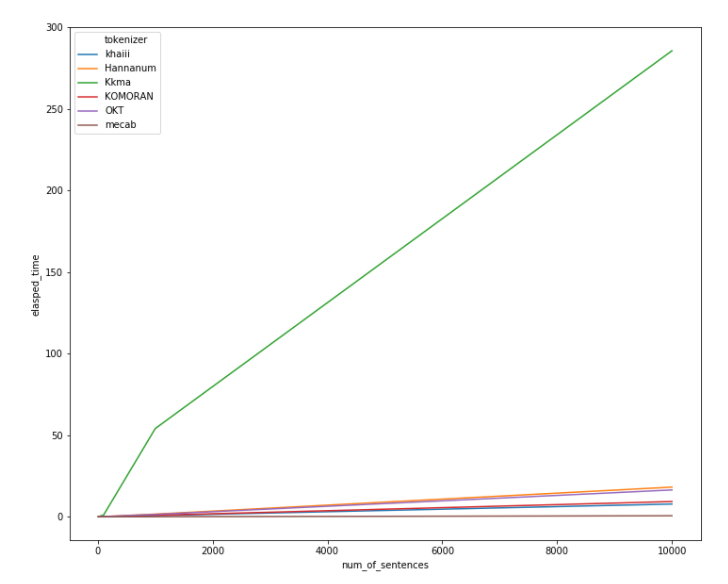

형태소 분석기 성능 비교 결과 kkma 분석기가 문장 갯수가 늘어날 수록 시간이 많이 소요되는 것을 알 수 있음

# Coount frequency After Extract noun

In [48]:
from konlpy.tag import Twitter
from collections import Counter

In [49]:
#konlpy의 tag
def get_tags(text, ntags=50):
    spliter = Twitter()
    nouns = spliter.nouns(text) #text에서 명사만 분리/추출
    count = Counter(nouns) # Counter객체를 생성하고 참조변수 nouns할당
    return_list = []  # 명사 빈도수 저장할 변수
    for n, c in count.most_common(ntags):
        temp = {'tag': n, 'count': c}
        return_list.append(temp)
    # most_common 메소드는 정수를 입력받아 객체 안의 명사중 빈도수
    # 큰 명사부터 순서대로 입력받은 정수 갯수만큼 저장되어있는 객체 반환
    # 명사와 사용된 갯수를 return_list에 저장합니다.
    return return_list 

In [ ]:
def main():
    text_file_name = "out.txt"
    # 분석할 파일
    noun_count = 20
    # 최대 많은 빈도수 부터 20개 명사 추출
    output_file_name = "count.txt"
    # count.txt 에 저장
    open_text_file = open(text_file_name, 'r',-1,"utf-8")
    # 분석할 파일을 open 
    text = open_text_file.read() #파일을 읽습니다.
    tags = get_tags(text, noun_count) # get_tags 함수 실행
    open_text_file.close()   #파일 close
    open_output_file = open(output_file_name, 'w',-1,"utf-8")
    # 결과로 쓰일 count.txt 열기
    for tag in tags:
        noun = tag['tag']
        count = tag['count']
        open_output_file.write('{} {}\n'.format(noun, count))
    # 결과 저장
    open_output_file.close() 
 
if __name__ == '__main__':
    main()
Colored by Color Scripter